# Visualizing embeddings


In [1]:
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
    AutoModelForQuestionAnswering, Trainer, TrainingArguments, HfArgumentParser, pipeline
from helpers import prepare_dataset_nli, prepare_train_dataset_qa, \
    prepare_validation_dataset_qa, QuestionAnsweringTrainer, compute_accuracy
import os
import json

NUM_PREPROCESSING_WORKERS = 2

In [2]:
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt

# map from words to embedded vector/matrices

In [3]:
def get_tensor(word):
    return torch.tensor(tokenizer(word)['input_ids'][1])

In [4]:
def get_embedding(word):
    tensor = get_tensor(word)
    return embeddings(tensor).detach()

In [5]:
def get_embedding_matrix(words):
    res = []
    for word in words:
        res.append(get_embedding(word))
    return torch.stack(res).numpy()

# word sets

In [6]:
antonyms = [('hungry', 'thirsty'),('visible', 'invisible'),('positive', 'negative'),('difficult', 'easy'),('progressive', 'conservative'),('fat', 'lean', 'thin'),('specific', 'general'),('active', 'passive'),('courageous', 'fearful'),('invisible', 'visible'),('unhappy', 'happy'),('uncomfortable', 'comfortable'),('organic', 'functional'),('pessimistic', 'optimistic'),('hopeful', 'hopeless'),('impatient', 'patient'),('conservative', 'progressive', 'liberal'),('stupid', 'intelligent', 'smart'),('negative', 'positive'),('rude', 'polite', 'civil'),('emotional', 'intellectual'),('irresponsible', 'responsible'),('evil', 'good'),('powerless', 'powerful'),('bad', 'good'),('corrupt', 'straight'),('defensive', 'offensive'),('cautious', 'brave'),('smart', 'stupid'),('individual', 'common'),('optimistic', 'pessimistic'),('insecure', 'secure'),('humble', 'proud'),('passive', 'active'),('dependent', 'independent'),('conspicuous', 'invisible'),('shy', 'confident'),('bright', 'dull', 'dim'),('good', 'ill', 'bad'),('reliable', 'unreliable'),('encouraging', 'discouraging'),('hungry', 'thirsty'),('useful', 'useless'),('empty', 'full'),('fine', 'harsh', 'coarse'),('available', 'unavailable'),('ugly', 'beautiful'),('friendly', 'hostile'),('positive', 'negative', 'neutral'),('difficult', 'easy'),('well', 'ill', 'sick', 'poorly', 'badly'),('beautiful', 'ugly'),('strange', 'familiar'),('here', 'there'),('cold', 'hot'),('intense', 'mild'),('dirty', 'clean'),('wise', 'foolish'),('black', 'white'),('active', 'quiet', 'passive', 'inactive'),('courageous', 'fearful', 'cowardly'),('sensitive', 'insensitive'),('effective', 'ineffective'),('happy', 'unhappy'),('found', 'lost', 'lose'),('safe', 'dangerous', 'unsafe'),('useless', 'useful'),('much', 'little', 'slight'),('strong', 'weak'),('brave', 'timid', 'cautious', 'fearful', 'cowardly'),('nice', 'nasty'),('white', 'black'),('unhappy', 'happy'),('excited', 'quiet', 'calm', 'still'),('healthy', 'unhealthy'),('unstable', 'stable'),('polite', 'rude'),('careful', 'careless'),('slow', 'fast', 'quickly'),('made', 'break'),('sick', 'well'),('familiar', 'strange', 'unusual', 'unfamiliar'),('similar', 'different'),('below', 'upstairs', 'above'),('tall', 'short', 'little'),('like', 'different', 'unlike'),('perfect', 'imperfect'),('poor', 'rich'),('worthless', 'valuable'),('quiet', 'active', 'noisy'),('lucky', 'unlucky'),('complete', 'incomplete'),('serious', 'playful'),('simple', 'complex'),('professional', 'amateur'),('new', 'old', 'worn'),('weak', 'strong'),('conservative', 'liberal', 'progressive'),('stupid', 'smart', 'intelligent'),('rude', 'polite', 'civil'),('proud', 'humble'),('afraid', 'fearless'),('emotional', 'cerebral'),('dishonest', 'honest', 'honorable'),('patient', 'impatient'),('cool', 'warm'),('respectful', 'disrespectful'),('easy', 'difficult', 'hard', 'quickly', 'uneasy'),('young', 'old'),('shown', 'hidden'),('evil', 'good'),('bad', 'good'),('sour', 'sweet'),('unknown', 'known'),('smart', 'stupid'),('hot', 'cold'),('optimistic', 'pessimistic'),('incomplete', 'complete'),('close', 'distant', 'open', 'remote', 'far'),('rich', 'poor', 'lean'),('humble', 'proud'),('confident', 'shy', 'timid', 'unsure'),('cheap', 'expensive'),('hard', 'soft', 'easy'),('dangerous', 'safe'),('late', 'early'),('complex', 'simple'),('clean', 'dirty'),('wrong', 'right', 'correct'),('small', 'large', 'big'),('popular', 'unpopular'),('warm', 'cool'),('private', 'public'),('tough', 'tender'),('honest', 'dishonest'),('unpredictable', 'predictable'),('old', 'young', 'new', 'immature'),('solid', 'liquid', 'hollow'),('shy', 'confident'),('big', 'small', 'little'),('ill', 'well'),('expensive', 'cheap', 'inexpensive'),('intelligent', 'stupid')]

In [235]:
intelligences = ['intelligent', 'smart', 'clever', 'dumb', 'stupid', 'idiotic']
colors = ['red', 'orange', 'gold', 'yellow', 'yellowgreen', 'green']
temperatures = ['hot', 'warm', 'cool', 'cold']
other_words = ['arbitrary', 'random', 'friendly', 'angry', 'goat', 'australia', 'billion', 'hunger', 'asbestos', 'operational', 'photos', 'document']

In [42]:
words = temperatures+other_words+intelligences

In [279]:
def distance_similarity(word1, word2):
    dist = torch.norm(get_embedding(word1) - get_embedding(word2))
    sim = torch.dot(get_embedding(word1), get_embedding(word2)) / (torch.norm(get_embedding(word1)) * torch.norm(get_embedding(word2)))
    return dist, sim

In [84]:
def print_similarity(wordset):
    print(wordset)
    for i, word1 in enumerate(wordset):
        for word2 in wordset[i+1:]:
            print(f'"{word1}" vs. "{word2}"')
            dist, sim = distance_similarity(word1, word2)
            print(f'distance: {float(dist):03f} | similarity: {float(sim):03f}')
            print()
        

# model - antoynm-negation2

In [163]:
# model pipeline (includes tokenization)
mp = pipeline("question-answering", model='experiments/antonym-negation2/model/', )
tokenizer = mp.tokenizer
model = mp.model
embeddings = model.get_input_embeddings()

In [164]:
X = get_embedding_matrix(words)
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [165]:
def get_embedding(word):
    tensor = get_tensor(word)
    return embeddings(tensor).detach()

In [166]:
def get_embedding_matrix(words):
    res = []
    for word in words:
        res.append(get_embedding(word))
    return torch.stack(res).numpy()

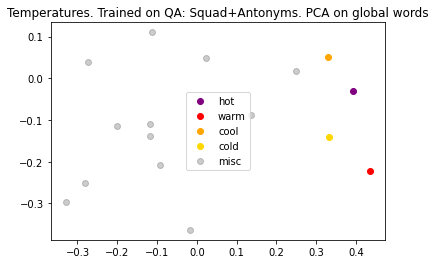

In [167]:
for i, word in enumerate(temperatures):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc', alpha=0.2)
plt.title('Temperatures. Trained on QA: Squad+Antonyms. PCA on global words')
plt.legend()

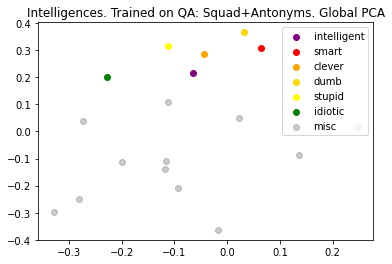

In [168]:
for i, word in enumerate(intelligences):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc', alpha=0.2)
plt.title('Intelligences. Trained on QA: Squad+Antonyms. Global PCA')
plt.legend()

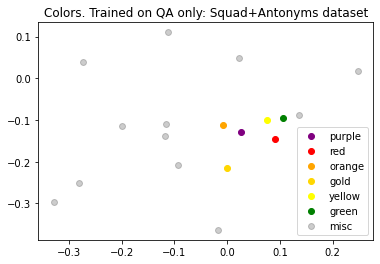

In [169]:
colors = ['purple', 'red', 'orange', 'gold', 'yellow', 'green']
for i, word in enumerate(colors):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc', alpha=0.2)
plt.title('Colors. Trained on QA only: Squad+Antonyms dataset')
plt.legend()

In [170]:
print_similarity(temperatures)

['hot', 'warm', 'cool', 'cold']
"hot" vs. "warm"
distance: 0.642609 | similarity: 0.192924

"hot" vs. "cool"
distance: 0.654469 | similarity: 0.177114

"hot" vs. "cold"
distance: 0.660369 | similarity: 0.174961

"warm" vs. "cool"
distance: 0.617772 | similarity: 0.191377

"warm" vs. "cold"
distance: 0.609189 | similarity: 0.198367

"cool" vs. "cold"
distance: 0.652154 | similarity: 0.163153



In [171]:
distances = similarities = 0.0
for antonym_pair in antonyms:
    d, s = distance_similarity(antonym_pair[0], antonym_pair[1])
    distances += d
    similarities += s
    
print(distances, similarities)

tensor(99.5758) tensor(22.1326)


# model - trained on mlm antonyms

In [284]:
# model pipeline (includes tokenization)
mp = pipeline("question-answering", model='experiments/mlm/model-mlm-generated-text/checkpoint-35000/', )
tokenizer = mp.tokenizer
model = mp.model
embeddings = model.get_input_embeddings()

Some weights of the model checkpoint at experiments/mlm/model-mlm-generated-text/checkpoint-35000/ were not used when initializing ElectraForQuestionAnswering: ['generator_predictions.dense.bias', 'generator_lm_head.weight', 'generator_predictions.dense.weight', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight']
- This IS expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at experiments/mlm/model-mlm-generated-text/check

In [285]:
X = get_embedding_matrix(words)
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [286]:
def get_embedding(word):
    tensor = get_tensor(word)
    return embeddings(tensor).detach()

In [287]:
def get_embedding_matrix(words):
    res = []
    for word in words:
        res.append(get_embedding(word))
    return torch.stack(res).numpy()

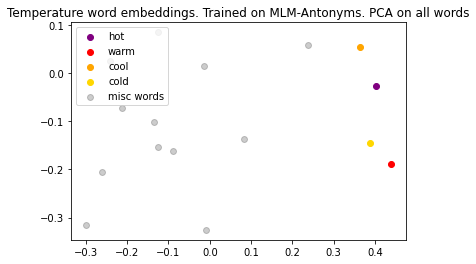

In [288]:
for i, word in enumerate(temperatures):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc words', alpha=0.2)
plt.title('Temperature word embeddings. Trained on MLM-Antonyms. PCA on all words')
plt.legend(loc='upper left')

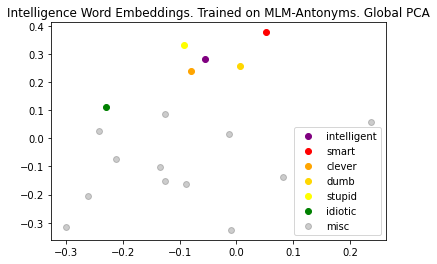

In [289]:
for i, word in enumerate(intelligences):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc', alpha=0.2)
plt.title('Intelligence Word Embeddings. Trained on MLM-Antonyms. Global PCA')
plt.legend()

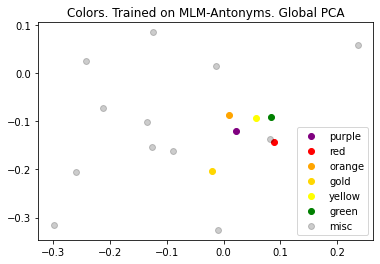

In [290]:
colors = ['purple', 'red', 'orange', 'gold', 'yellow', 'green']
for i, word in enumerate(colors):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc', alpha=0.2)
plt.title('Colors. Trained on MLM-Antonyms. Global PCA')
plt.legend()

In [291]:
print_similarity(temperatures)

['hot', 'warm', 'cool', 'cold']
"hot" vs. "warm"
distance: 0.642223 | similarity: 0.469967

"hot" vs. "cool"
distance: 0.633813 | similarity: 0.469359

"hot" vs. "cold"
distance: 0.586180 | similarity: 0.552299

"warm" vs. "cool"
distance: 0.603020 | similarity: 0.525763

"warm" vs. "cold"
distance: 0.578368 | similarity: 0.569528

"cool" vs. "cold"
distance: 0.647147 | similarity: 0.445955



In [292]:
distances = similarities = 0.0
for antonym_pair in antonyms:
    d, s = distance_similarity(antonym_pair[0], antonym_pair[1])
    distances += d
    similarities += s
    
print(distances, similarities)

tensor(96.2545) tensor(60.3368)


# model - pretrained Electra embeddings

In [271]:
# model pipeline (includes tokenization)
mp = pipeline("question-answering", model='google/electra-small-discriminator')
tokenizer = mp.tokenizer
model = mp.model
embeddings = model.get_input_embeddings()

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForQuestionAnswering: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['qa_outputs.weight', 'qa_output

In [272]:
X = get_embedding_matrix(words)
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [273]:
def get_embedding(word):
    tensor = get_tensor(word)
    return embeddings(tensor).detach()

In [274]:
def get_embedding_matrix(words):
    res = []
    for word in words:
        res.append(get_embedding(word))
    return torch.stack(res).numpy()

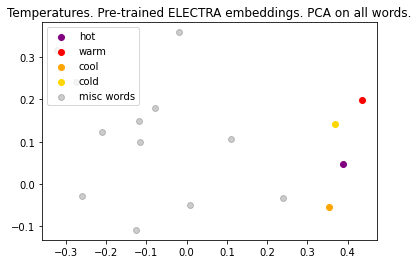

In [275]:
for i, word in enumerate(temperatures):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc words', alpha=0.2)
plt.title('Temperatures. Pre-trained ELECTRA embeddings. PCA on all words.')
plt.legend(loc='upper left')

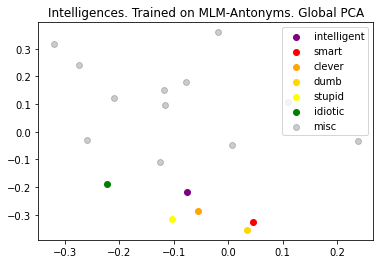

In [276]:
for i, word in enumerate(intelligences):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc', alpha=0.2)
plt.title('Intelligences. Trained on MLM-Antonyms. Global PCA')
plt.legend()

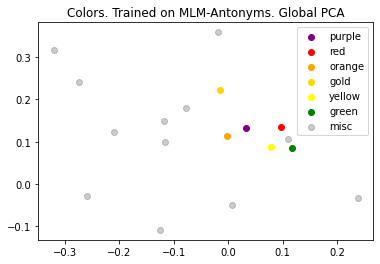

In [277]:
colors = ['purple', 'red', 'orange', 'gold', 'yellow', 'green']
for i, word in enumerate(colors):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc', alpha=0.2)
plt.title('Colors. Trained on MLM-Antonyms. Global PCA')
plt.legend()

In [280]:
print_similarity(temperatures)

['hot', 'warm', 'cool', 'cold']
"hot" vs. "warm"
distance: 0.617350 | similarity: 0.504326

"hot" vs. "cool"
distance: 0.620163 | similarity: 0.497491

"hot" vs. "cold"
distance: 0.587842 | similarity: 0.548226

"warm" vs. "cool"
distance: 0.582283 | similarity: 0.553412

"warm" vs. "cold"
distance: 0.549413 | similarity: 0.602154

"cool" vs. "cold"
distance: 0.629533 | similarity: 0.475181



In [281]:
distances = similarities = 0.0
for antonym_pair in antonyms:
    d, s = distance_similarity(antonym_pair[0], antonym_pair[1])
    distances += d
    similarities += s
    
print(distances, similarities)

tensor(96.3011) tensor(59.3858)


# model results plots

Text(0.5, 1.0, 'ELECTRA scores on SQuAD, trained 4 ways')

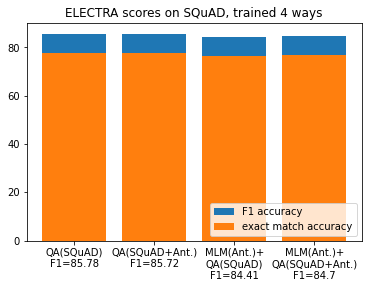

In [282]:
f1 = [85.78, 85.72, 84.41, 84.7]
models = ['QA(SQuAD)', 'QA(SQuAD+Ant.)', 'MLM(Ant.)+\nQA(SQuAD)', 'MLM(Ant.)+\nQA(SQuAD+Ant.)']
labels = [f"{m}\nF1={f}" for m, f in zip(models, f1)]
plt.bar(label='F1 accuracy', x=labels, height=f1)
plt.bar(label='exact match accuracy', x=labels, height=[77.67, 77.74, 76.46, 76.82])
plt.legend(loc='lower right')
plt.title('ELECTRA scores on SQuAD, trained 4 ways')

Text(0.5, 1.0, 'ELECTRA Scores on CheckList, trained 4 ways')

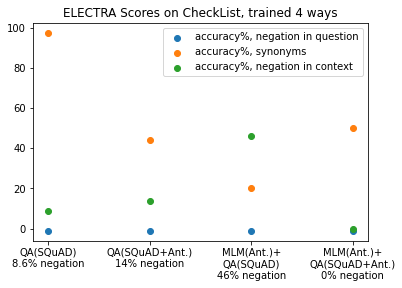

In [283]:
scores = [8.6, 14, 46, 0]
models = ['QA(SQuAD)', 'QA(SQuAD+Ant.)', 'MLM(Ant.)+\nQA(SQuAD)', 'MLM(Ant.)+\nQA(SQuAD+Ant.)']
labels = [f"{m}\n{f}% negation" for m, f in zip(models, scores)]
plt.scatter(label='accuracy%, negation in question', x=labels, y=[-1, -1, -1, -1,])
plt.scatter(label='accuracy%, synonyms', x=labels, y=[97.3, 44, 20, 50,])
plt.scatter(label='accuracy%, negation in context', x=labels, y=scores)
plt.legend(loc='upper right')
plt.title('ELECTRA Scores on CheckList, trained 4 ways')

In [190]:
import pandas as pd

In [215]:
df = pd.read_csv('./stock_squad_train_loss.csv', header=None, index_col=0)
df = df.rename(columns={1: 'Train Loss'})

<AxesSubplot:title={'center':'Training ELECTRA on SQuAD'}, xlabel='Optimizer Step #'>

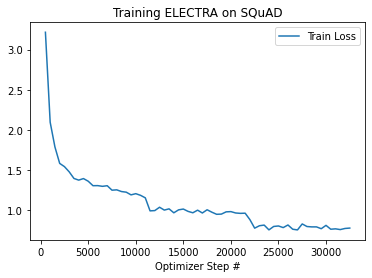

In [221]:
df.plot(title='Training ELECTRA on SQuAD', xlabel='Optimizer Step #')


In [267]:
df = pd.read_csv('./train_loss_different_data.csv', index_col='optimizer step')

<AxesSubplot:title={'center':'Train Loss'}, xlabel='optimizer step'>

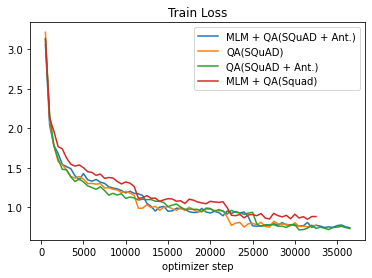

In [269]:
df.plot(title='Train Loss')